# The determinant of credit  and borrower interest rate from Prosper Loan Data 
## _by Ahmad Sabbah


## Investigation Overview

Prosper is a money lending platform which helps in reducing the distance between the borrower and lender(peer-to-peer lending process). The objective of this work is to look at the main determinants of loans and borrowers interest rate that could be used to predict their evolution. The main focus was on several borrowers information, such as income, occupation, interest rate ....


## Dataset Overview

The Prosper loan dataset comprises of 113937 loan entries with 81 attributes on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others, from the year 2009-2014. There are two main categories:
* Borrower information:  Basic attributes of the borrowers such as annual income, condition of employment, interest rate, loan status, etc.
* Loan performance information: Metrics evaluating the risk associated with the loans such as Prosper score and bank card utilization, etc.

There were some elements that need to be fixed, in order to create interesting and trustworthy analyses and visualizations.

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

#size of graphics
plt.rcParams["axes.grid"] = False
plt.style.use('default')

In [2]:
# load in the dataset into a pandas dataframe
df_loan=pd.read_csv("C:\\Users\\HITECH\\OneDrive\\Desktop\\Prosper-Loan-Data-Analysis-main\prosperLoanData.csv")

In [3]:
# Define features of interest for this analysis
features = ['ListingNumber','ListingCreationDate','ProsperRating (Alpha)','ProsperScore',\
            'ListingCategory (numeric)', 'Occupation','EmploymentStatus', \
            'IsBorrowerHomeowner', 'CurrentCreditLines', 'OpenRevolvingAccounts', 'DebtToIncomeRatio', \
            'IncomeVerifiable', 'LoanOriginalAmount', 'LoanStatus', \
            'CreditScoreRangeLower', 'CreditScoreRangeUpper','BorrowerState', \
            'LoanOriginationDate', 'IncomeRange','BorrowerAPR','BorrowerRate','StatedMonthlyIncome','Term']


In [4]:
#new subdataset
df_selected=df_loan[features]

In [5]:
# According to my preliminary analysis, ProsperRating is the most important feature of this dataset
#so i will select only not null rows 
df_selected=df_selected[df_selected['ProsperRating (Alpha)'].notnull()]

In [6]:
#Filling missing values with mean
df_selected['DebtToIncomeRatio']=df_selected['DebtToIncomeRatio'].fillna(df_selected['DebtToIncomeRatio'].mean())

In [14]:
df_selected['ListingNumber']=df_selected['ListingNumber'].astype(str)

In [15]:
df_selected['ProsperScore']=df_selected['ProsperScore'].astype(int)

In [16]:
list_dict = {0 : 'Not Available', 1 : 'Debt Consolidation', 2 : 'Home Improvement', 3: 'Business', 
             4 : 'Personal Loan', 5 : 'Student Use', 6 : 'Auto', 7 : 'Other', 8 : 'Baby&Adoption', 
             9 : 'Boat', 10 : 'Cosmetic Procedure', 11 : 'Engagement Ring', 12 : 'Green Loans',
             13 : 'Household Expenses', 14 : 'Large Purchases', 15 : 'Medical/Dental', 16 : 'Motorcycle',
             17 : 'RV', 18 : 'Taxes', 19 : 'Vacation', 20 : 'Wedding Loans'}

df_selected['ListingCategory'] = df_selected['ListingCategory (numeric)'].map(list_dict)
df_selected.drop(['ListingCategory (numeric)'], axis=1, inplace=True)

In [17]:
# convert string to ordinal category type
ordinal_rating = ['AA', 'A', 'B', 'C', 'D', 'E','HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_rating)
df_selected['ProsperRating'] = df_selected['ProsperRating (Alpha)'].astype(ordered_var)

In [18]:
# calcute averge Credit Score Range
df_selected['CreditScore_average'] = (df_selected['CreditScoreRangeLower'] + df_selected['CreditScoreRangeUpper'])/2

In [19]:
# define a classification function
def classify(row):
    if row["StatedMonthlyIncome"]<2500:
        return 'Low'
    if row["StatedMonthlyIncome"]<8000:
        return 'Medium'
    else:
        return 'High'
    
df_selected['WageGroup'] = df_selected.apply(classify, axis=1)

# convert string to ordinal category type
ordinal_class = ['Low', 'Medium', 'High']
ordered_variabl = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_class)
df_selected['WageGroup'] = df_selected['WageGroup'].astype(ordered_variabl)

_**Note that the above cells have been set as "Skip"-type slides. That means that when the notebook is rendered as http slides, those cells won't show up.**_

## Loan Status Distribution

More than 80% of all Prosper loans are either current or completed (good profiles). Among them, almost 67% are current and being paid by Prosper's borrowers. However, about 8% of Prosper's loans were charged-off or defaulted. Moreover, the remaining 2.4% of loans has the status Past Due and was grouped under a single status: Past Due.

In [20]:
# Aggregate Past Due loans 
df_selected['LoanStatus'] = df_selected['LoanStatus'].apply(lambda x: x if 'Past Due' not in x else 'Past Due')

# Convert LoanStatus to a categorical variable
status_dict = ['Defaulted','Chargedoff', 'Past Due', 'Current', 'FinalPaymentInProgress', 'Completed']

loan_status_order = pd.api.types.CategoricalDtype(ordered = True, categories = status_dict)

df_selected['LoanStatus'] = df_selected['LoanStatus'].astype(loan_status_order)

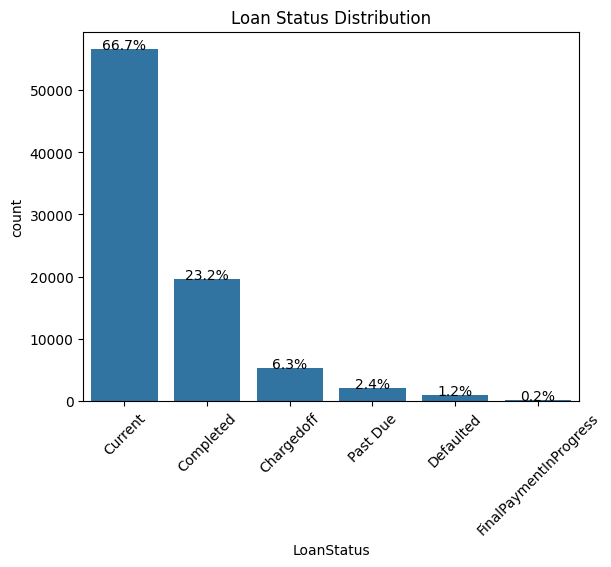

In [21]:
# Print the proportion below the bars 
n_loans=df_selected['LoanStatus'].value_counts().sum()
status_count=df_selected['LoanStatus'].value_counts()
status_order=status_count.index

base_color = sb.color_palette()[0]
sb.countplot(data=df_selected, x='LoanStatus', color=base_color, order=status_order);

# get the current tick locations and labels
locs, labels = plt.xticks(rotation=45) 

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    count = status_count[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_loans)

    # print the annotation just below the top of the bar
    plt.text(loc, count+2, pct_string, ha = 'center', color = 'black')
    
plt.title('Loan Status Distribution');

## Loan Original Amount Distribution

As we can see, there are three peaks at 4K, 10K, and 15K. It seems that these three loan sizes are the most common ones that people took out.

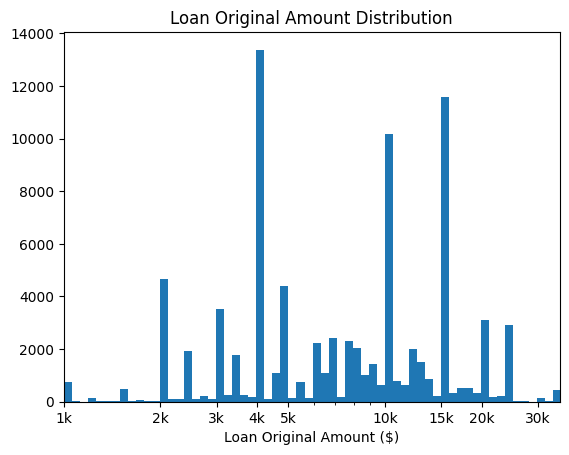

In [22]:
# Plot the loan original amount against a log scale because it has a long tail
log_binsize = 0.025
bins_log = 10 ** np.arange(3, np.log10(df_selected['LoanOriginalAmount'].max())+log_binsize, log_binsize)
plt.hist(data = df_selected, x = 'LoanOriginalAmount', bins = bins_log)
plt.xscale('log')
x_ticks = [1000, 2000, 3000, 4000, 5000, 10000, 15000,20000, 30000]
x_ticks_names = ['1k','2k', '3k', '4k', '5k', '10k','15k', '20k','30k']
plt.xticks(x_ticks, x_ticks_names)
plt.xlim((1000,35000))
plt.xlabel('Loan Original Amount ($)')
plt.title('Loan Original Amount Distribution');

## Relationship between Borrower Rate and Employment status, Collateral and Wage Group

As expected, it appears that there are some negative relationships between the categorical/ordinal variables selected and the interest rate. 

At first, Unemployed people have more restrictive credit condition (higher rate) than the people who have jobs. 

The second observation is that borrowers who have collaterals(or homeowners) have lower rates than those who doesn't have any collateral(house).

Similarly, borrowers with higher monthly salaries tend to get a lower lending interest rate. So it's a good determinant as well.

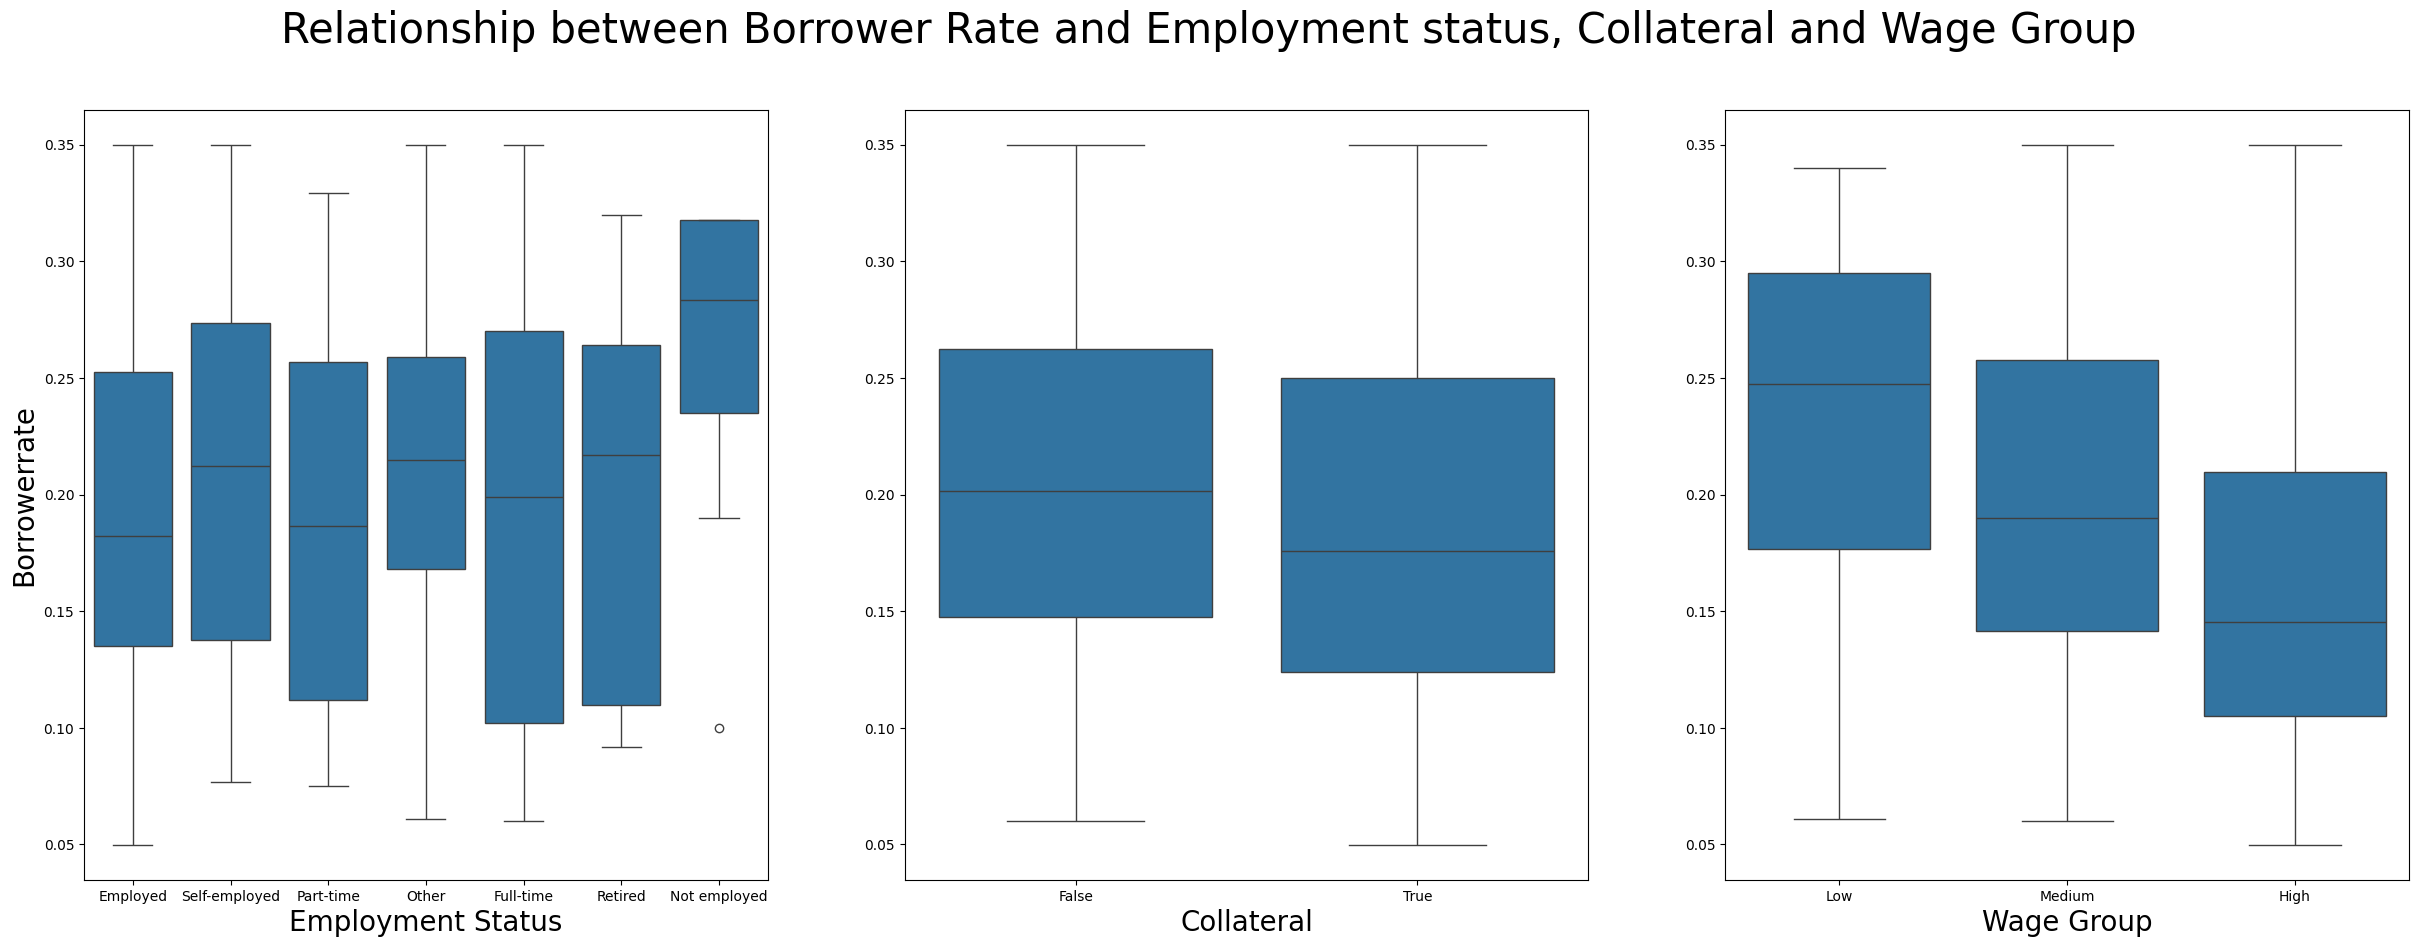

In [23]:
df_samp = df_selected.sample(2000, replace=False)
# assist function for plotting 
def boxgrid(var, color):
    fig, ax = plt.subplots(ncols = 3, figsize = [30,10])
    sb.boxplot(data = df_samp, y = var, x = 'EmploymentStatus', ax = ax[0],
                  color = color)
    ax[0].set_xlabel("Employment Status",fontsize=20)
    ax[0].set_ylabel(var.capitalize(), fontsize=20)
    sb.boxplot(data = df_samp, y = var, x = 'IsBorrowerHomeowner', ax = ax[1],
               color = color)
    ax[1].set_xlabel("Collateral",fontsize=20)
    ax[1].set_ylabel("")
    sb.boxplot(data = df_samp, y = var, x = 'WageGroup', ax = ax[2],
               color = color)

    ax[2].set_xlabel("Wage Group", fontsize=20)
    ax[2].set_ylabel("")
    fig.suptitle('Relationship between Borrower Rate and Employment status, Collateral and Wage Group', fontsize=30)
    plt.show()
    
boxgrid('BorrowerRate', sb.color_palette()[0])


## Relation between Borrower Rate and Prosper Score, Prosper Rating

Not surprisingly, there is a strong indication that the Prosper score/rating is an excellent determinant factor of borrower's rate. We can conclude that the higher the score , the lower the rate.
Similarly, borrowers with AA prosper ratings could expect an APR that will likely fall into the 2-15% range, whereas borrowers with bad ratings (HR) could expect their interest rate to go as high as 40%!

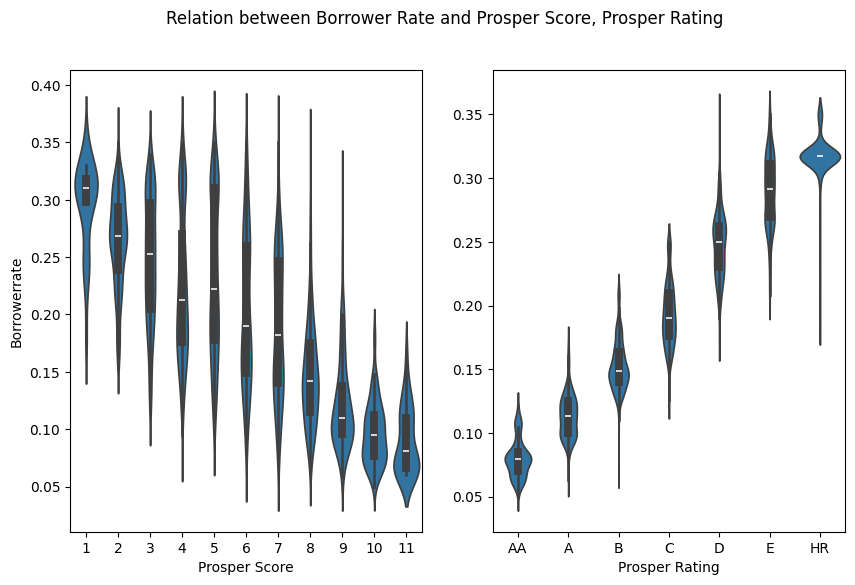

In [24]:
# assist function for plotting 
def violin(var, color):
    fig, ax = plt.subplots(ncols = 2, figsize = [10,6])
    sb.violinplot(data = df_samp, y = var, x = 'ProsperScore', ax = ax[0],
                  color = color)
    ax[0].set_xlabel("Prosper Score")
    ax[0].set_ylabel(var.capitalize())
    sb.violinplot(data = df_samp, y = var, x = 'ProsperRating', ax = ax[1],
               color = color)

    ax[1].set_xlabel("Prosper Rating")
    ax[1].set_ylabel("")
    fig.suptitle('Relation between Borrower Rate and Prosper Score, Prosper Rating')
    plt.show()
    
violin('BorrowerRate', sb.color_palette()[0])

## Borrower Rate and Average Credit Score by Delinquency Status

It's clear that for people who are delinquent (defaulted,past due, charged-off payments), banks applies more restrictive credit conditions (higher interest rates). Also these people have lower credit scores than people with good status.

In [25]:
#Create a new column which return 1 for good status of payment('Current','Completed','FinalPaymentInProgress') 
# and 0 if there is an issue (defaulted,past due, charged-off payments)

status_good=['Current','Completed','FinalPaymentInProgress']
def cat_Loanstatus(row):
    for i in status_good:
        if i in row:
            return 1
    return 0
df_selected["loanstatus_cat"] = df_selected.LoanStatus.apply(lambda x: cat_Loanstatus(x))

In [26]:
status = df_selected.groupby('loanstatus_cat').agg({'CreditScore_average':'mean','BorrowerRate':'mean'})
status = status.reset_index()
status["loanstatus_cat"].replace({0: "Delinquent", 1: "Good"}, inplace=True)
status = status.sort_values(['CreditScore_average'],ascending=False).head(10)

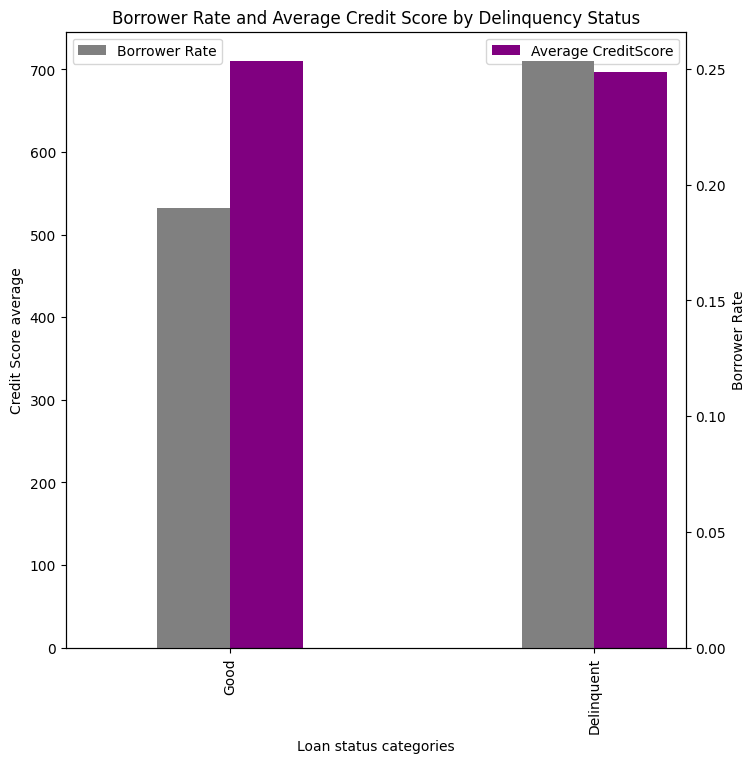

In [27]:
# Create a figure
fig = plt.figure(figsize=(8,8))
# Create matplotlib axes
ax = fig.add_subplot(111)
# Create another axes 
ax2 = ax.twinx()

width = 0.20
CreditScore_average = status.plot(x='loanstatus_cat', y='CreditScore_average', kind='bar', color = 'purple',
                   width=width,ax=ax, position = 0, label = 'Average CreditScore')
BorrowerRate = status.plot(x='loanstatus_cat', y='BorrowerRate', kind='bar', color = 'gray',
                  width=width,ax=ax2, position = 1,  label = 'Borrower Rate')

ax.set_ylabel('Credit Score average')
CreditScore_average.legend(loc='upper right')
ax2.set_ylabel('Borrower Rate')
ax2.legend(loc='upper left')
ax.set_xlabel('Loan status categories')
plt.title('Borrower Rate and Average Credit Score by Delinquency Status');


## Borrower Rate by Prosper Rating and Loan terms

We note that the rates applied on 5-year loans are generally higher than the rates applied on other maturities, regardless of the prosper rating (with the exception of the E rating (same rates for 3 and 5 years loans ) and the HR rating).
This is obvious, when the duration is longer it increases the risk of this operation involving a rise in rates. 
Of course, as it is always mentioned, the rates are the lowest, for individuals with a good rating.
Interestingly, for HR rating, only 3 years loans are observed in this dataset.

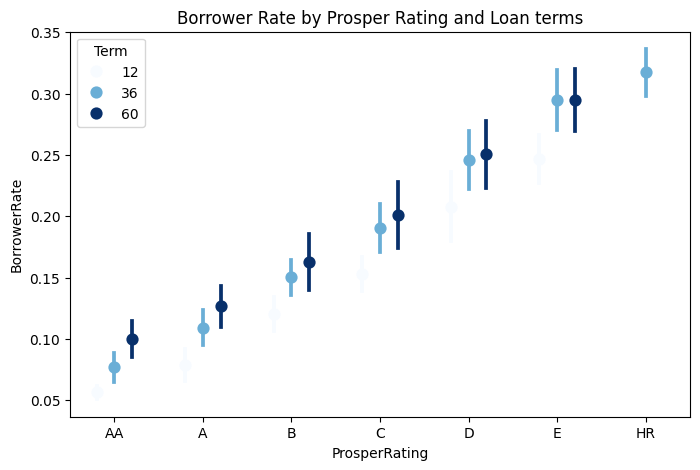

In [28]:
#plot pointplot 
fig = plt.figure(figsize = [8,5])
ax = sb.pointplot(data = df_selected, x = 'ProsperRating', y = 'BorrowerRate', hue = 'Term',
           palette = 'Blues', linestyles = '',dodge = 0.4, ci='sd')
plt.title('Borrower Rate by Prosper Rating and Loan terms');

## Loan amount by collateral and wage group

As shown in the previous section, having a collateral and a higher wage help getting higher loan amount.
It is clearly visible that being a home owner and a good salary is a very important element to get a higher loan amount.

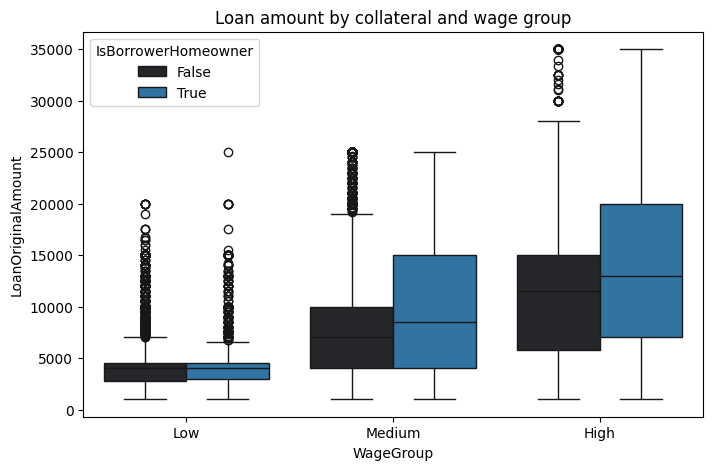

In [29]:
#plot boxplot
plt.figure(figsize = [8,5])
sb.boxplot(data = df_selected, x = 'WageGroup', y = 'LoanOriginalAmount',hue = 'IsBorrowerHomeowner' ,color = base_color);
plt.title('Loan amount by collateral and wage group');

# Thank you for your attention

In [30]:
!jupyter nbconvert --to html slide_deck_template.ipynb


[NbConvertApp] Converting notebook slide_deck_template.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 759240 bytes to slide_deck_template.html
